# Grid ERDDAP Based Prawler Data

- 1m bins for saving

- plots have 2m interpolation filled and 3hr interpolation filled

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import xarray as xa
import cmocean as cm

import datetime
import EcoFOCIpy.io.erddap as erddap

In [2]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8082/erddap'
dataset_name = 'erddap_17ckitaem2a_prawler'
e = ERDDAP(server=server_url,
          protocol='tabledap',
          response='csv')

e.dataset_id=dataset_name

pdf = e.to_pandas(
            index_col='time (UTC)',
            parse_dates=True,
            skiprows=(1,)  # units information can be dropped.
        )
pdf.columns = [x.split()[0] for x in pdf.columns]
pdf.index.name = pdf.index.name.split()[0]
pdf.index = pdf.index.tz_localize(None)

pdf = pdf.reset_index()

pdf.dropna(subset=['time'],inplace=True)

In [3]:
pdf

,time,profileid,Chlorophyll,Oxy_Sat,Temperature,Oxy_Temperature,Salinity,depth,SigmaT,Turbidity,Oxy_Conc,longitude,latitude
0,2017-07-29 07:15:00,17ckitaem2a_p0003,0.305,100.157210,5.587,5.596,31.767,6.0,25.047340,0.120,303.42360,195.743,71.22
1,2017-07-29 07:15:00,17ckitaem2a_p0003,0.316,100.223820,5.609,5.602,31.777,5.9,25.052708,0.126,303.44412,195.743,71.22
2,2017-07-29 07:15:00,17ckitaem2a_p0003,0.237,100.250275,5.612,5.606,31.780,6.0,25.054731,0.132,303.49527,195.743,71.22
3,2017-07-29 07:15:00,17ckitaem2a_p0003,0.271,100.178070,5.622,5.637,31.778,5.8,25.051994,0.158,303.21088,195.743,71.22
4,2017-07-29 07:15:00,17ckitaem2a_p0003,0.169,100.268845,5.642,5.623,31.782,6.0,25.052841,0.126,303.33325,195.743,71.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,2017-09-05 22:11:15,17ckitaem2a_p0422,1.322,97.149750,5.207,5.247,31.718,23.4,25.051485,0.170,297.05280,195.743,71.22
13221,2017-09-05 22:11:15,17ckitaem2a_p0422,2.350,97.122740,5.181,5.217,31.718,25.4,25.054358,0.227,297.15002,195.743,71.22
13222,2017-09-05 22:11:15,17ckitaem2a_p0422,1.345,97.083730,5.166,5.191,31.721,27.2,25.058386,0.139,297.12628,195.743,71.22
13223,2017-09-05 22:11:15,17ckitaem2a_p0422,1.480,97.014260,4.894,4.924,31.750,29.4,25.110874,0.139,298.76007,195.743,71.22


In [4]:
try:
    pdf.profileid
except:
    pdf = pdf.rename({'profile_id':'profileid'},axis=1)

try:
    pdf.profileid
except:
    pdf = pdf.rename({'profileNum':'profileid'},axis=1)

In [5]:
#collapse time
for g,groups in pdf[pdf.columns].groupby('profileid'):
    pdf.loc[groups.index,'time'] = pdf.loc[groups.index]['time'].iloc[0]

In [6]:
binave1m = (pdf.assign(CUT=pd.cut(pdf['depth'], right=False,
                      bins=np.arange(0.5,75,1),
                      labels=np.arange(1,75,1))
          )
   .groupby(['profileid','CUT'], as_index=False, observed=True).median()
)
binave1m_counts = (pdf.assign(CUT=pd.cut(pdf['depth'], right=False, 
                      bins=np.arange(0.5,75,1),
                      labels=np.arange(1,75,1))
          )
   .groupby(['profileid','CUT'], as_index=False, observed=True).count()['Temperature']
)
binave1m['depth'] = binave1m.depth.round()
binave1m['counts'] = (pdf.assign(CUT=pd.cut(pdf['depth'], right=False,
                      bins=np.arange(0.5,75,1),
                      labels=np.arange(1,75,1))
          )
   .groupby(['profileid','CUT'], as_index=False, observed=True).count()['Temperature']
)


In [7]:
binave1m = binave1m.set_index(['time','depth'])

In [8]:
init = True

for g,groups in binave1m[binave1m.columns].groupby('time'):
    if init:
        xdf = groups[~groups.index.duplicated()].to_xarray()
        init = False
    else:
        xdf = xa.merge([xdf,groups[~groups.index.duplicated()].to_xarray()])

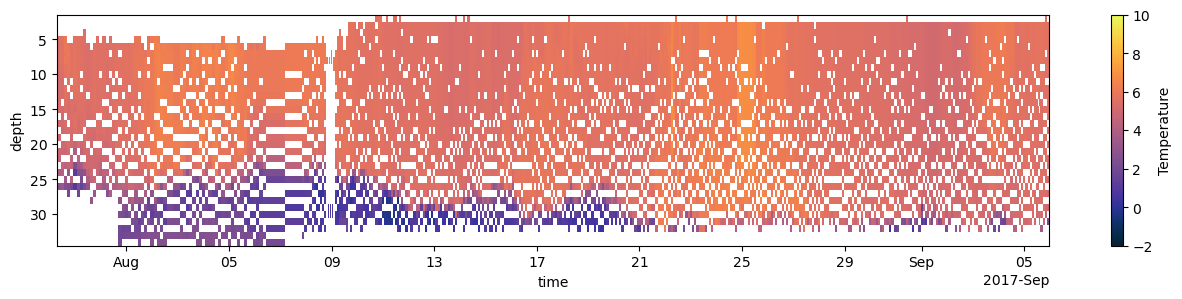

In [9]:
(xdf.Temperature.T.plot(cmap=cm.cm.thermal,vmin=-2,vmax=10, yincrease=False,figsize=(16,3)))

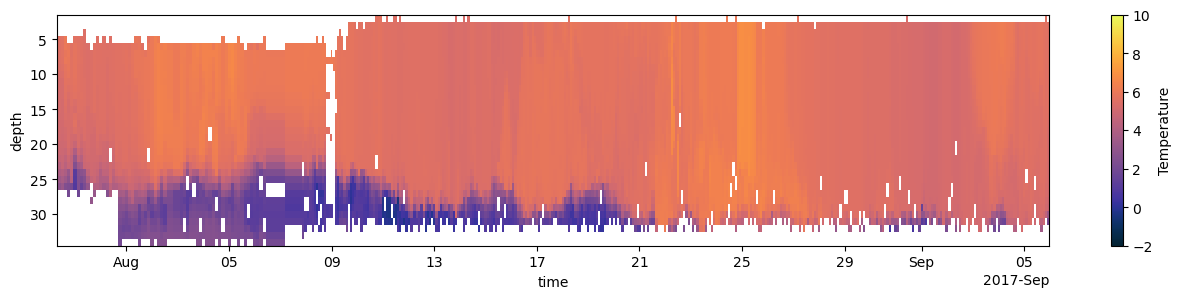

In [10]:
(xdf.Temperature.T.interpolate_na('depth',max_gap=2).
                   interpolate_na('time',max_gap='3h').
                    plot(cmap=cm.cm.thermal,vmin=-2,vmax=10, yincrease=False,figsize=(16,3)))

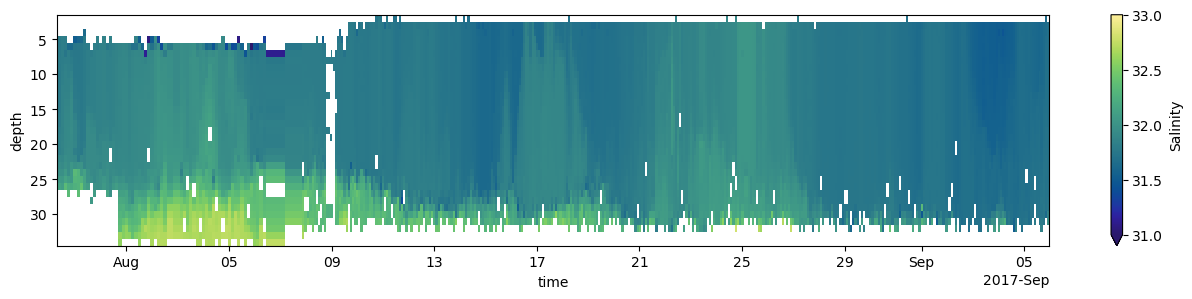

In [11]:
(xdf.Salinity.T.interpolate_na('depth',max_gap=2).
                   interpolate_na('time',max_gap='3h').
                    plot(cmap=cm.cm.haline,vmin=31,vmax=33, yincrease=False,figsize=(16,3)))

In [12]:
xdf.to_netcdf(f'{dataset_name}.1m.nc',encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_77557/2065085877.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'seconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(f'{dataset_name}.1m.nc',encoding={'time':{'units':'days since 1900-01-01'}})


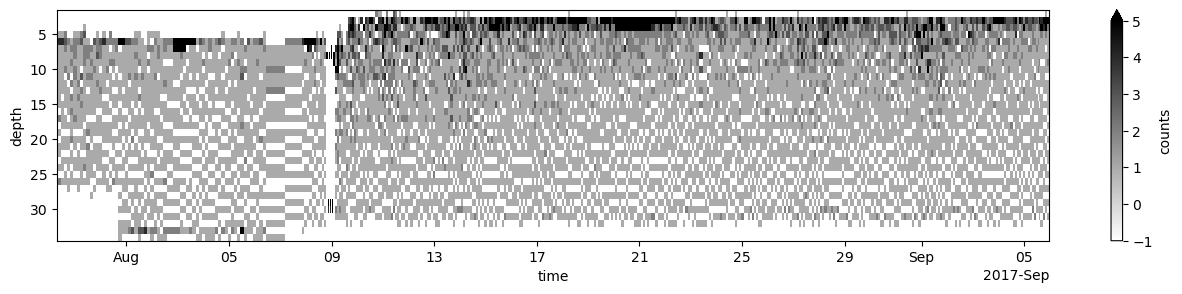

In [14]:
xdf.counts.T.plot(vmax=5, vmin=-1, cmap='gist_gray_r', yincrease=False,figsize=(16,3))